In [1]:
import numpy as np
import time
from sklearn import svm
import sys
from cvxopt import matrix, solvers
import pickle

In [2]:
def create_gaussian_kernel(gamma=0.001):
    def kernel(x, z):
        xx = (x**2).sum(axis=1).reshape(-1,1)@np.ones((1,z.shape[0]))
        zz = (z**2).sum(axis=1).reshape(-1,1)@np.ones((1,x.shape[0]))
        return np.exp(-gamma*(xx + zz.T - 2*x@z.T))
    
    return kernel

def linear_kernel(x, z):
    return x@z.T
      
class SoftKernelSVM_QP:
    
    def __init__(self, kernel, C=1):
        self.C = C
        self.kernel = kernel
        
    def learn(self, X, y, thresh=1e-6):
        alphas = np.array(self.sol['x'])
        idx = (alphas > thresh).flatten()
        self.sv_idxs = idx.nonzero()[0]
        print(f"Got {len(self.sv_idxs)} support vectors")
        self.sv = X[idx]
        self.sv_y = y[idx]
        self.alphas = alphas[idx]

        if (self.kernel == linear_kernel):
            self.w = self.sv.T @ (self.alphas * self.sv_y)
        
        self.b = self.sv_y - np.sum(self.kernel(self.sv,self.sv) * self.alphas * self.sv_y, axis=0)
        self.b = np.mean(self.b)
    
   # X, y need to be numpy arrays
    def fit(self, X, y):
        m, n = X.shape
        p_np = (y @ y.T) * self.kernel(X,X)
        P = matrix(p_np, tc='d') # half not required
        q = matrix(-np.ones((m, 1)), tc='d')
        A = matrix(y.T, tc='d')
        b = matrix(np.zeros(1), tc='d')
        G = matrix(np.vstack([-np.eye(m), np.eye(m)]), tc='d')
        h = matrix(np.hstack([np.zeros(m), self.C*np.ones(m)]).reshape(-1,1), tc='d')
        
        self.sol = solvers.qp(P, q, G, h, A, b)

    def predict(self, X):
        prod = np.sum(self.kernel(self.sv,X) * self.alphas * self.sv_y, axis=0) + self.b
        return prod

In [10]:
def eq_block(x, y):
    i = 0
    while i < len(x)-1 and y[i] == y[i+1]:
        i += 1
    return i

class MultiClassSoftKernelSVM_QP:
    
    def __init__(self, kernel, C=1.0):
        self.kernel = kernel
        self.C = C
        self.svms = {}
        
    def extract_binary_problem(X, y, i, j):
        idx = ((y == i) | (y == j)).flatten()
        X = X[idx,:]
        y = y[idx]
        y = np.where(y == j, 1, -1)      
        return (X,y)
        
    def fit(self, X, y):
        # get the number of distinct classes first
        self.classes = np.unique(y)
        self.n_classes = len(self.classes)
        # now make a list of tuples, defining the models. (a,b) => -1->a, 1->b
        for i in range(len(self.classes)):
            for j in range(i+1,len(self.classes)):
                svm = SoftKernelSVM_QP(self.kernel, C=self.C)
                # transform y and x to make
                Xp, yp = MultiClassSoftKernelSVM_QP.extract_binary_problem(X, y, self.classes[i], self.classes[j])
                svm.fit(Xp, yp)
                svm.learn(Xp, yp)
                self.svms[(i,j)] = svm
    
    def predict(self, X):
        m, n = X.shape
        counts = np.zeros((m,self.n_classes))
        scores = np.zeros((m,self.n_classes))
        for (i,j) in self.svms:
            score = self.svms[(i,j)].predict(X)
            pred = np.sign(score)
            pred = (pred+1)>>1 # convert to (0,1) predictions
            counts[:,i] += (1-pred)
            counts[:,j] += pred
            scores[:,i] -= (1-pred)*score
            scores[:,j] += pred*score
        
        predictions = np.zeros(m)
        counts_args = np.argsort(counts, axis=1)
        break_args = np.zeros(m)
        for i in range(m):
            eqlen = eq_block(counts_args[i],counts[i])
            if eqlen != 0:
                a = counts_args[i]
                max_j = 0
                for j in range(1,eqlen+1):
                    if scores[i][a[j]] > scores[i][a[max_j]]:
                        max_j = j
                predictions[i] = self.classes[a[max_j]]
            else:
                predictions[i] = self.classes[counts_args[i][0]]
        
        return predictions

In [11]:
def load_data(dir, type):
    data_file = open(f'{dir}/{type}.pickle', 'rb')
    data = pickle.load(data_file)
    data_file.close()

    s = data['data'].shape
    data['data'] = data['data'].reshape(s[0], np.product(s[1:]))

    data['data'] = data['data'].astype(np.double)
    data['labels'] = data['labels'].astype(np.double)

    data['data'] = np.interp(data['data'], (0,255), (0,1))
    
    return data

## Testing

In [7]:
dpath = '../data/part2_data'
train_data = load_data(dpath, 'train_data')
test_data = load_data(dpath, 'test_data')

In [12]:
model = MultiClassSoftKernelSVM_QP(create_gaussian_kernel())
model.fit(train_data['data'], train_data['labels'])

     pcost       dcost       gap    pres   dres
 0: -1.7375e+03 -9.9396e+03  5e+04  3e+00  8e-13
 1: -1.2403e+03 -6.7355e+03  8e+03  2e-01  9e-13
 2: -1.2970e+03 -2.2257e+03  1e+03  2e-02  8e-13
 3: -1.4964e+03 -1.8419e+03  4e+02  7e-03  8e-13
 4: -1.5732e+03 -1.7274e+03  2e+02  2e-03  8e-13
 5: -1.6089e+03 -1.6741e+03  7e+01  6e-04  9e-13
 6: -1.6279e+03 -1.6465e+03  2e+01  1e-04  9e-13
 7: -1.6345e+03 -1.6374e+03  3e+00  1e-05  1e-12
 8: -1.6357e+03 -1.6359e+03  2e-01  8e-07  1e-12
 9: -1.6358e+03 -1.6358e+03  6e-03  2e-08  1e-12
10: -1.6358e+03 -1.6358e+03  2e-04  4e-10  1e-12
Optimal solution found.
Got 2002 support vectors
     pcost       dcost       gap    pres   dres
 0: -2.1327e+03 -1.2308e+04  7e+04  3e+00  9e-13
 1: -1.4701e+03 -8.9057e+03  1e+04  3e-01  1e-12
 2: -1.5068e+03 -2.6512e+03  1e+03  2e-02  1e-12
 3: -1.7461e+03 -2.2149e+03  5e+02  6e-03  9e-13
 4: -1.8559e+03 -2.0435e+03  2e+02  2e-03  1e-12
 5: -1.8986e+03 -1.9835e+03  9e+01  7e-04  1e-12
 6: -1.9209e+03 -1.953

KeyboardInterrupt: 

In [16]:
import pickle
preds = pickle.load(open('Qc/preds.pkl', 'rb'))
preds_sk = pickle.load(open('Qc/preds_sk.pkl', 'rb'))
preds_true = test_data['labels'].flatten()

In [19]:
from PIL import Image
def save_mismatches(preds, dataset, prefix):
    trues = dataset['labels'].flatten()
    idxs = np.where(preds != trues)[0]
    random_idxs = np.random.choice(idxs, size=10, replace=False)
    vecs = [(255*dataset['data'][i]).reshape(32,32,3).astype(np.uint8) for i in random_idxs]
    for (i,vec) in enumerate(vecs):
        img = Image.fromarray(vec)
        img = img.resize((320,320), resample=Image.NEAREST)
        img.save(f"Qc/mc_{prefix}_{int(preds[random_idxs[i]])}{int(trues[random_idxs[i]])}_{i+1}.png")

In [20]:
save_mismatches(preds, test_data, 'qp')

In [21]:
save_mismatches(preds_sk, test_data, 'sk')

In [26]:
import os
l = os.listdir('Qc')
l.sort()

In [27]:
l

['mc_qp_01_4.png',
 'mc_qp_01_9.png',
 'mc_qp_02_7.png',
 'mc_qp_04_6.png',
 'mc_qp_21_3.png',
 'mc_qp_24_2.png',
 'mc_qp_31_10.png',
 'mc_qp_34_8.png',
 'mc_qp_42_5.png',
 'mc_qp_43_1.png',
 'mc_sk_01_10.png',
 'mc_sk_02_8.png',
 'mc_sk_13_4.png',
 'mc_sk_23_7.png',
 'mc_sk_24_2.png',
 'mc_sk_24_5.png',
 'mc_sk_31_1.png',
 'mc_sk_31_3.png',
 'mc_sk_34_9.png',
 'mc_sk_42_6.png',
 'preds.pkl',
 'preds_sk.pkl',
 'qp_cmat.pdf',
 'sk_cmat.pdf']

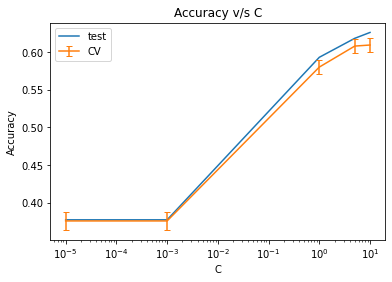

In [40]:
import matplotlib.pyplot as plt
times = np.array([[0.39,   0.37,   0.3615, 0.3905, 0.3665],
                  [0.39,   0.37,   0.3615, 0.3905, 0.3665],
                  [0.5925, 0.586,  0.5635, 0.582,  0.576 ],
                  [0.6175, 0.6195, 0.6015, 0.599,  0.602 ],
                  [0.6205, 0.6195, 0.594,  0.6055, 0.607 ]])
means = times.mean(axis=1)
stdevs = times.std(axis=1)
test_accs = np.array([0.3772, 0.3772, 0.593, 0.6182, 0.626])
c = [1e-5,1e-3,1,5,10]

plt.plot(c, test_accs, label='test')
plt.errorbar(c, means, yerr=stdevs, capsize=3, label='CV')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy v/s C')
plt.legend()
plt.savefig('Qd/acc.pdf', bbox_inches='tight')
plt.show()